# Imports

In [1]:
import numpy as np
import librosa 
from os import environ
environ["MEDLEYDB_PATH"] = "/Datasets/MedleyDB"
import medleydb as mdb
import sklearn
import os
import sox
import tempfile as tmp
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier

# Getting list of multitracks without bleed

In [2]:
loader = mdb.load_all_multitracks()
no_bleed_mtracks = []
for mtrack in loader:
    print mtrack.track_id
    if not mtrack.has_bleed:
        no_bleed_mtracks.append(mtrack)

AClassicEducation_NightOwl
AimeeNorwich_Child
AimeeNorwich_Flying
AlexanderRoss_GoodbyeBolero
AlexanderRoss_VelvetCurtain
AmarLal_Rest
AmarLal_SpringDay1
Auctioneer_OurFutureFaces
AvaLuna_Waterduct
BigTroubles_Phantom
BrandonWebster_DontHearAThing
BrandonWebster_YesSirICanFly
CelestialShore_DieForUs
ChrisJacoby_BoothShotLincoln
ChrisJacoby_PigsFoot
ClaraBerryAndWooldog_AirTraffic
ClaraBerryAndWooldog_Boys
ClaraBerryAndWooldog_Stella
ClaraBerryAndWooldog_TheBadGuys
ClaraBerryAndWooldog_WaltzForMyVictims
Creepoid_OldTree
CroqueMadame_Oil
CroqueMadame_Pilot
Debussy_LenfantProdigue
DreamersOfTheGhetto_HeavyLove
EthanHein_1930sSynthAndUprightBass
EthanHein_BluesForNofi
EthanHein_GirlOnABridge
EthanHein_HarmonicaFigure
FacesOnFilm_WaitingForGa
FamilyBand_Again
Grants_PunchDrunk
Handel_TornamiAVagheggiar
HeladoNegro_MitadDelMundo
HezekiahJones_BorrowedHeart
HopAlong_SisterCities
InvisibleFamiliars_DisturbingWildlife
JoelHelander_Definition
JoelHelander_ExcessiveResistancetoChange
JoelHelander

# Get instrument labels

In [4]:
#list of all possible instrument labels
valid_labels = mdb.multitrack.get_valid_instrument_labels()

# Loop over instrument to get files

In [5]:
file_dict = {}
#dictionary of list of labels for every multitrack without bleed

for label in valid_labels:
    label_list = list(mdb.utils.get_files_for_instrument(label, multitrack_list = no_bleed_mtracks))
    #list of labels of multitracks with no bleed
    
    if len(label_list) == 0:
        continue
    file_dict[label] = label_list


# Compute MFCC

In [64]:
mfcc_list = []
label_list = []
mfcc_dict = {}
label_index = 0

# loop over instrument labels
# for label in list(file_dict.keys()):
target_names = ["piano", "violin", "male singer", "drum set", "distorted electric guitar", "oud", "tuba", "claps", "timpani"]
for label in target_names:
    print label
    if label == "fx/processed sound":
        continue
    print len(file_dict[label])
    
    folder_name = "instrument_mfcc"
    instrument_file = os.path.join(folder_name,"%s.npy" % label)
    label_file = os.path.join(folder_name,"%s-label.npy" % label)
    
    if os.path.exists(instrument_file) and os.path.exists(label_file):
        print "loading existing file..."
        master_instrument_mfcc_matrix = np.load(instrument_file) 
        master_instrument_label_matrix = np.load(label_file)
        
        if master_instrument_mfcc_matrix.shape[0] != 40:
            os.remove(instrument_file)
            os.remove(label_file)
            continue
            
        print master_instrument_mfcc_matrix.shape
        print master_instrument_label_matrix.shape
        
    else:
        print "creating new file..."
        instrument_mfcc_list = []
        instrument_label_list = []

        # loop over files for instruments
        for fpath in file_dict[label]:
            print fpath
            # normalizing volume, removing silence
            temp_fpath = tmp.NamedTemporaryFile(suffix=".wav")
            tfm = sox.Transformer()
            tfm.norm(db_level=-6)
            tfm.silence()
            tfm.build(fpath, temp_fpath.name)

            # load audio
            y, fs = librosa.load(temp_fpath.name)

            # compute MFCCs
            M = librosa.feature.mfcc(y, sr=fs, n_mfcc=40)

            lab = np.zeros((len(M[0]), )) + label_index
            instrument_mfcc_list.append(M)
            instrument_label_list.append(lab)

#         n_examples = len(instrument_mfcc_list)
#         n_examples_train = int(np.floor(0.75 * n_examples))
        
#         instrument_mfcc_list_train = instrument_mfcc_list[:n_examples_train]
#         instrument_mfcc_list_test = instrument_mfcc_list[n_examples_train:]
                                                        
        master_instrument_mfcc_matrix = np.hstack(instrument_mfcc_list)
        print instrument_mfcc_matrix.shape
        np.save(instrument_file, master_instrument_mfcc_matrix)

        master_instrument_label_matrix = np.hstack(instrument_label_list)      
        np.save(label_file, master_instrument_label_matrix)
            
    # creating labels
    mfcc_list.append(master_instrument_mfcc_matrix)
    label_list.append(master_instrument_label_matrix)
        
    print ""
    label_index = label_index + 1

piano
27
loading existing file...
(40, 210330)
(210330,)

violin
14
loading existing file...
(40, 185797)
(185797,)

male singer
41
loading existing file...
(40, 204633)
(204633,)

drum set
60
loading existing file...
(40, 376034)
(376034,)

distorted electric guitar
31
loading existing file...
(40, 159333)
(159333,)

oud
2
loading existing file...
(40, 15312)
(15312,)

tuba
2
loading existing file...
(40, 1514)
(1514,)

claps
5
loading existing file...
(40, 5402)
(5402,)

timpani
6
loading existing file...
(40, 4880)
(4880,)



In [94]:
mfcc_list
print (len(mfcc_list))
print (mfcc_list[0].shape)
print (mfcc_list[-1].shape)

9
(40, 210330)
(40, 4880)


In [95]:
mfcc_matrix = np.hstack(mfcc_list).T
label_matrix = np.hstack(label_list)

In [96]:
print mfcc_matrix.shape
print label_matrix.shape

(1163235, 40)
(1163235,)


In [97]:
np.save("mfcc_matrix.npy", mfcc_matrix)
np.save("label_matrix.npy", label_matrix)

# Standardizing MFCC Matrix

In [98]:
mfcc_means = np.mean(mfcc_matrix, axis = 0)
mfcc_std = np.std(mfcc_matrix, axis=0)

np.save("mfcc_means.npy", mfcc_means)
np.save("mfcc_std.npy", mfcc_std)

mfcc_matrix_normal = (mfcc_matrix - mfcc_means)/mfcc_std

label_values = list(file_dict.keys())
np.save("label_values.npy", label_values)

In [70]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(mfcc_matrix_normal, label_matrix, test_size=0.25)

# Plot MFCC Data Matrix

In [71]:
label_index_list = np.arange(len(label_values))
plt.figure(figsize = (30, 50))

start_index=0
end_index=-1

plt.subplot(2,2,1)
# plt.imshow(mfcc_matrix[start_index:end_index, 0:2].T, origin = "lower", interpolation='none')
plt.plot(mfcc_matrix[:, 0])
plt.plot(mfcc_matrix[:, 1])
plt.plot(mfcc_matrix[:, 2])
# plt.colorbar()
plt.axis("auto")
plt.axis("tight")
plt.xlabel("Example Number")
plt.ylabel("MFCC Coefficient")

plt.subplot(2,2,3)
plt.plot(label_matrix[start_index:end_index], "o")
plt.axis("auto")
plt.axis("tight")
plt.xlabel("Example Number")
plt.ylabel("Instrument Label Number")
plt.yticks(label_index_list, label_values, rotation='horizontal')

plt.subplot(2,2,2)
# plt.imshow(mfcc_matrix_normal[start_index:end_index, 0:2].T, origin = "lower", interpolation='none')
# plt.colorbar()
plt.plot(mfcc_matrix_normal[:, 0])
plt.plot(mfcc_matrix_normal[:, 1])
plt.plot(mfcc_matrix_normal[:, 2])
plt.axis("auto")
plt.axis("tight")
plt.xlabel("Example Number")
plt.ylabel("Standardized MFCC Coefficient")

plt.subplot(2,2,4)
plt.plot(label_matrix[start_index:end_index], "o")
plt.axis("auto")
plt.axis("tight")
plt.xlabel("Example Number")
plt.ylabel("Instrument Label Number")
plt.yticks(label_index_list, label_values, rotation='horizontal')

plt.show()

KeyboardInterrupt: 

In [72]:
print "training classifier with weighted classes"
clf = RandomForestClassifier(n_estimators = 10, class_weight = "balanced") #weighted based on class occurance
clf.fit(x_train, y_train)

print "training classifier with unweighted classes"
clf2 = RandomForestClassifier(n_estimators = 10, class_weight = None) #unweighted based on class occurance
clf2.fit(x_train, y_train)

print "saving classifiers"
from sklearn.externals import joblib
joblib.dump(clf, "instrument_classifier.pkl")
joblib.dump(clf2, "instrument_classifier2.pkl")


training classifier with weighted classes
training classifier with unweighted classes
saving classifiers


['instrument_classifier2.pkl']

In [73]:
#weighted scores
training_score = clf.score(x_train, y_train) #how well classifer makes model to fit data
testing_score = clf.score(x_test, y_test) #how well the model generalizes to new data

print ("training_score_weighted:" )
print training_score
print ("testing_score_weighted:" )
print testing_score

#unweighted scores
training_score2 = clf2.score(x_train, y_train) #how well classifer makes model to fit data
testing_score2 = clf2.score(x_test, y_test) #how well the model generalizes to new data

print ("training_score_unweighted:" )
print training_score2
print ("testing_score_unweighted:" )
print testing_score2


training_score_weighted:
0.999431470406
testing_score_weighted:
0.977779229666
training_score_unweighted:
0.999428031718
testing_score_unweighted:
0.979839000856


# Classification Metrics and Confusion Matrix

In [75]:
from sklearn.metrics import classification_report

y_predicted = clf.predict(x_test)
y_predicted2 = clf2.predict(x_test)

target_names = ["piano", "violin", "male singer", "drum set", "distorted electric guitar", "oud", "tuba", "claps", "timpani"]

print "Classification metrics for unweighted model"
print(classification_report(y_test, y_predicted2, target_names=target_names))

print "Classification metrics for weighted_model"
print(classification_report(y_test, y_predicted, target_names=target_names))

Classification metrics for unweighted model
                           precision    recall  f1-score   support

                    piano       0.99      0.98      0.98     39829
                   violin       0.98      1.00      0.99     93928
              male singer       0.97      0.77      0.86      3784
                 drum set       1.00      0.93      0.96      1298
distorted electric guitar       0.99      1.00      0.99     46693
                      oud       0.99      0.72      0.83      1204
                     tuba       0.99      0.81      0.89       358
                    claps       0.97      0.99      0.98     52690
                  timpani       0.98      0.95      0.97     51025

              avg / total       0.98      0.98      0.98    290809

Classification metrics for weighted_model
                           precision    recall  f1-score   support

                    piano       0.99      0.98      0.98     39829
                   violin       0.98   

In [92]:
from sklearn.metrics import confusion_matrix

print "Confusion Matrix for unweighted model"
print target_names
c_mat2 = confusion_matrix(y_test, y_predicted2)
support = np.sum(c_mat, axis=1).astype(float)
print support
print (np.round(c_mat2/support, 3))

print "Confusion Matrix for weighted model"
print target_names
c_mat = confusion_matrix(y_test, y_predicted)
print (np.round(c_mat/support, 3))


Confusion Matrix for unweighted model
['piano', 'violin', 'male singer', 'drum set', 'distorted electric guitar', 'oud', 'tuba', 'claps', 'timpani']
[ 39829.  93928.   3784.   1298.  46693.   1204.    358.  52690.  51025.]
[[ 0.979  0.002  0.003  0.     0.     0.002  0.     0.009  0.003]
 [ 0.001  0.995  0.001  0.002  0.001  0.002  0.     0.001  0.006]
 [ 0.002  0.001  0.765  0.     0.001  0.002  0.     0.008  0.005]
 [ 0.     0.     0.     0.926  0.     0.     0.     0.     0.001]
 [ 0.     0.     0.002  0.     0.996  0.     0.     0.001  0.002]
 [ 0.001  0.     0.002  0.     0.     0.718  0.     0.005  0.   ]
 [ 0.     0.     0.     0.     0.     0.001  0.81   0.001  0.   ]
 [ 0.003  0.003  0.003  0.     0.002  0.002  0.     0.988  0.003]
 [ 0.005  0.014  0.009  0.003  0.004  0.001  0.008  0.011  0.954]]
Confusion Matrix for weighted model
['piano', 'violin', 'male singer', 'drum set', 'distorted electric guitar', 'oud', 'tuba', 'claps', 'timpani']
[[ 0.975  0.002  0.004  0.     0.00

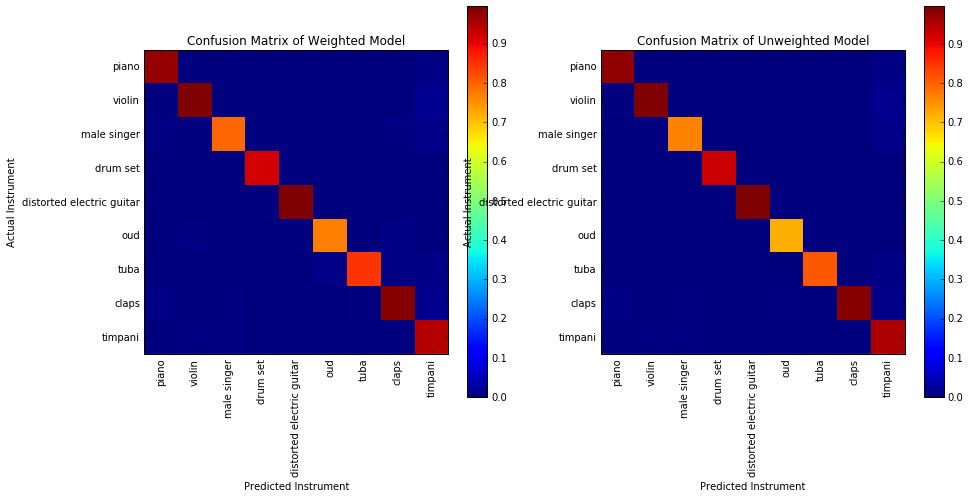

In [93]:
plt.figure(figsize=(15, 7))

plt.subplot(1,2,1)
plt.title("Confusion Matrix of Weighted Model")
plt.imshow((c_mat/support).T, origin="upper", interpolation="none")
plt.colorbar()
target_index = range(len(target_names))
plt.xticks(target_index, target_names, rotation="vertical")
plt.xlabel("Predicted Instrument")
plt.yticks(target_index, target_names)
plt.ylabel("Actual Instrument")

plt.subplot(1,2,2)
plt.title("Confusion Matrix of Unweighted Model")
plt.imshow((c_mat2/support).T, origin="upper", interpolation="none")
plt.colorbar()
target_index = range(len(target_names))
plt.xticks(target_index, target_names, rotation="vertical")
plt.xlabel("Predicted Instrument")
plt.yticks(target_index, target_names)
plt.ylabel("Actual Instrument")

In [27]:
#IRRELEVANT NOW
# def clf_predict(audio_fpath, clf, mfcc_means, mfcc_std):
#     # normalizing volume, removing silence
#     temp_fpath = tmp.NamedTemporaryFile(suffix=".wav")
#     tfm = sox.Transformer()
#     tfm.norm(db_level=-6)
#     tfm.silence()
#     tfm.build(audio_fpath, temp_fpath.name)
        
#     # load audio
#     y, fs = librosa.load(temp_fpath.name)
        
#     # compute MFCCs
#     M = librosa.feature.mfcc(y, sr=fs, n_mfcc=40)
    
#     M_normal = (M - mfcc_means)/mfcc_std
    
#     predicted_label = clf.predict(M_normal.T)
    